# scDoRI downstream analysis

In [2]:
import logging
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from scdori import (
    trainConfig,
    load_scdori_inputs,
    set_seed,
    scDoRI,
    load_best_model,
    compute_neighbors_umap,
    compute_topic_peak_umap,
    compute_topic_gene_matrix,
    compute_atac_grn_activator_with_significance,
    compute_atac_grn_repressor_with_significance,
    compute_significant_grn,
    plot_topic_activation_heatmap,
    get_top_activators_per_topic,
    get_top_repressor_per_topic,
    compute_activator_tf_activity_per_cell,
    compute_repressor_tf_activity_per_cell,
    save_regulons,
    get_latent_topics,
    get_tf_expression
)


logger = logging.getLogger(__name__)
logging.basicConfig(level=trainConfig.logging_level)

#### Loading and preparing data for training and model initialisation

In [3]:
logger.info("Starting scDoRI downstream analysis")
set_seed(trainConfig.random_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

INFO:__main__:Starting scDoRI downstream analysis
INFO:scdori._core.utils:Random seed set to 200.
INFO:__main__:Using device: cuda:0


## 1. load data

uses the path specified in config file to load processed RNA and ATAC anndata as well as precomputed insilico-chipseq matrix and peak-gene distances

In [4]:
rna_metacell, atac_metacell, gene_peak_dist, insilico_act, insilico_rep = (
    load_scdori_inputs(trainConfig)
)
gene_peak_fixed = gene_peak_dist.clone()
gene_peak_fixed[gene_peak_fixed > 0] = 1  # mask for peak-gene links based on distance

INFO:scdori._core.data_io:Loading RNA from /data/m015k/new_metacells/data_gastrulation_single_cell/generated/rna_processed.h5ad
INFO:scdori._core.data_io:Loading ATAC from /data/m015k/new_metacells/data_gastrulation_single_cell/generated/atac_processed.h5ad
INFO:scdori._core.data_io:Loading gene-peak dist from /data/m015k/new_metacells/data_gastrulation_single_cell/generated/gene_peak_distance_exp.npy
INFO:scdori._core.data_io:Loading insilico embeddings from /data/m015k/new_metacells/data_gastrulation_single_cell/generated/insilico_chipseq_act.npy & /data/m015k/new_metacells/data_gastrulation_single_cell/generated/insilico_chipseq_rep.npy


## 2. computing indices of genes which are TFs and setting number of cells per metacell ( set to 1 for single cell data)

In [5]:
# computing indices of genes which are TFs and setting number of cells per metacell ( set to 1 for single cell data)
rna_metacell.obs["num_cells"] = 1
rna_metacell.var["index_int"] = range(rna_metacell.shape[1])
tf_indices = rna_metacell.var[rna_metacell.var.gene_type == "TF"].index_int.values
num_cells = rna_metacell.obs.num_cells.values.reshape((-1, 1))

## 3. onehot encoding the batch column for entire dataset

In [6]:
batch_col = trainConfig.batch_col
rna_metacell.obs["batch"] = rna_metacell.obs[batch_col].values
atac_metacell.obs["batch"] = atac_metacell.obs[batch_col].values
# obtaining onehot encoding for technical batch,

enc = OneHotEncoder(handle_unknown="ignore")
enc.fit(rna_metacell.obs["batch"].values.reshape(-1, 1))

onehot_batch = enc.transform(rna_metacell.obs["batch"].values.reshape(-1, 1)).toarray()
enc.categories_

[array(['E7.5_rep1', 'E7.5_rep2', 'E7.75_rep1', 'E8.0_rep1', 'E8.0_rep2',
        'E8.5_CRISPR_T_KO', 'E8.5_CRISPR_T_WT', 'E8.5_rep1', 'E8.5_rep2',
        'E8.75_rep1', 'E8.75_rep2'], dtype=object)]

## 5. Build scDoRI model using parameters from config file

In [7]:
num_genes = rna_metacell.n_vars
num_peaks = atac_metacell.n_vars

num_tfs = insilico_act.shape[1]

num_batches = onehot_batch.shape[1]
model = scDoRI(
    device=device,
    num_genes=num_genes,
    num_peaks=num_peaks,
    num_tfs=num_tfs,
    num_topics=trainConfig.num_topics,
    num_batches=num_batches,
    dim_encoder1=trainConfig.dim_encoder1,
    dim_encoder2=trainConfig.dim_encoder2,
).to(device)

#### Downstream analysis

scDoRI supports a comprehensive suite of downstream analyses for single-cell multiome RNA-ATAC data. These include dimensionality reduction using latent topics, identification of gene and peak programs associated with each topic, inference of enhancer–gene interactions, and construction of topic-specific transcription factor–gene regulatory networks (GRNs).

We demonstrate these capabilities using the mouse gastrulation dataset from https://www.biorxiv.org/content/10.1101/2022.06.15.496239v1

## 10. Load best checkpoint model

In [8]:
model = load_best_model(
    model, Path(trainConfig.weights_folder_grn) / "best_scdori_best_eval.pth", device
)

INFO:scdori._core.downstream:Loaded best model weights from /data/m015k/weights/weights_directory_grn/best_scdori_best_eval.pth


## 11. Computing and visualising latent topic activity per cell

In [9]:
# creating dataloader for all cells
n_cells = rna_metacell.n_obs
indices = np.arange(n_cells)

all_dataset = TensorDataset(torch.from_numpy(indices))
all_dataset_loader = DataLoader(
    all_dataset, batch_size=trainConfig.batch_size_cell_prediction, shuffle=False
)

In [10]:
# get scDoRI latent embedding (topics)
scdori_latent = get_latent_topics(
    model,
    device,
    all_dataset_loader,
    rna_metacell,
    atac_metacell,
    num_cells,
    tf_indices,
    onehot_batch,
)

Extracting latent topics: 100%|██████████| 112/112 [01:33<00:00,  1.19it/s]


In [11]:
# adding scDoRI embedding to the anndata object
rna_metacell.obsm["X_scdori"] = scdori_latent

In [12]:
## adding color palette
colPalette_celltypes = [
    "#532C8A",
    "#c19f70",
    "#f9decf",
    "#c9a997",
    "#B51D8D",
    "#3F84AA",
    "#9e6762",
    "#354E23",
    "#F397C0",
    "#ff891c",
    "#635547",
    "#C72228",
    "#f79083",
    "#EF4E22",
    "#989898",
    "#7F6874",
    "#8870ad",
    "#647a4f",
    "#EF5A9D",
    "#FBBE92",
    "#139992",
    "#cc7818",
    "#DFCDE4",
    "#8EC792",
    "#C594BF",
    "#C3C388",
    "#0F4A9C",
    "#FACB12",
    "#8DB5CE",
    "#1A1A1A",
    "#C9EBFB",
    "#DABE99",
    "#65A83E",
    "#005579",
    "#CDE088",
    "#f7f79e",
    "#F6BFCB",
]

cell_type_sorted = sorted(list(set(rna_metacell.obs["celltype"].values)))

color_dict = dict(zip(cell_type_sorted, colPalette_celltypes, strict=False))

col_sorted = []
for i in sorted(cell_type_sorted):
    col_sorted.append(color_dict[i])

rna_metacell.uns["celltype_colors"] = col_sorted
# rna_metacell.uns['celltype_plot_colors']= col_sorted
# rna_ad_tl.uns['celltype_colors']= col_sorted

In [13]:
# computing neighbourhood graph and UMAP based on scDoRI embedding, UMAP parameters can be set in config file
compute_neighbors_umap(
    rna_metacell,
    rep_key="X_scdori",
    umap_n_neighbors=trainConfig.umap_n_neighbors,
    umap_min_dist=trainConfig.umap_min_dist,
    umap_random_state=trainConfig.umap_random_state
)

INFO:scdori._core.downstream:=== Computing neighbors + UMAP on scDoRI latent ===
INFO:scdori._core.downstream:Done. UMAP stored in rna_anndata.obsm['X_umap'].


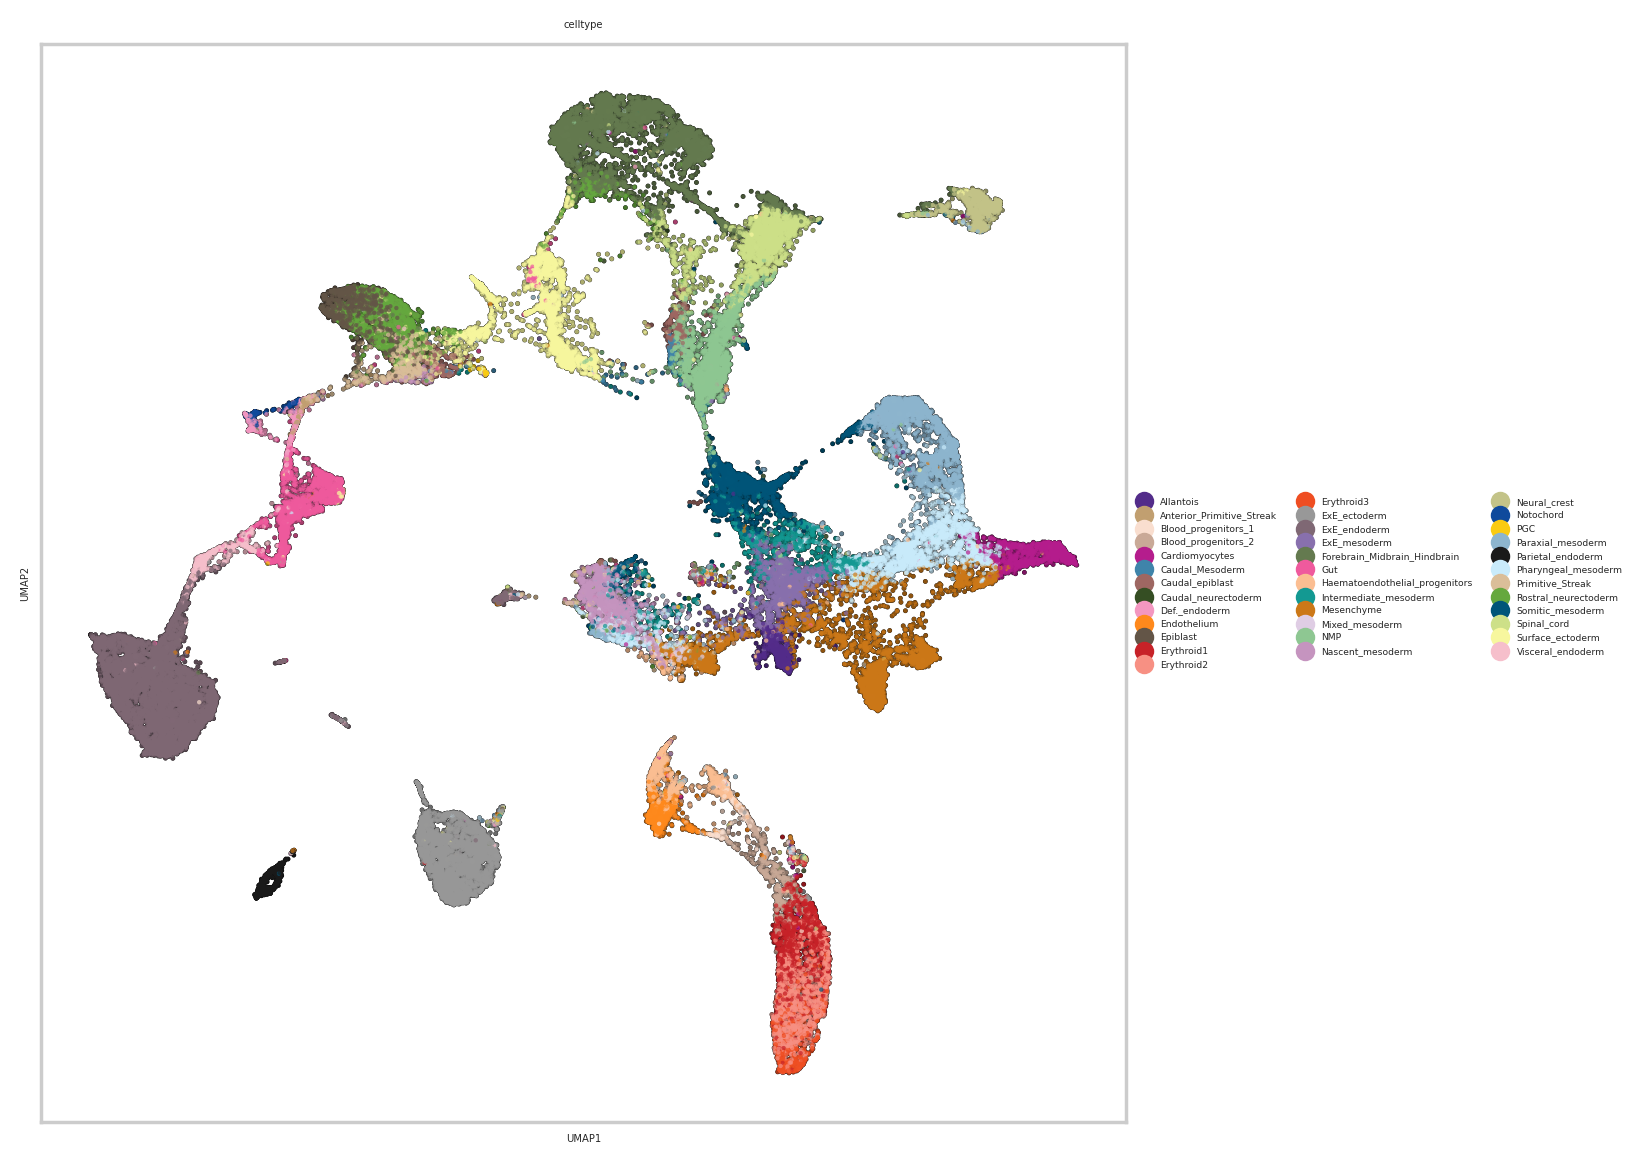

In [14]:
# visualing cell-types on scDoRI computed UMAP
sns.set(font_scale=0.3)
sns.set_style("whitegrid")
with plt.rc_context({"figure.figsize": (7, 7), "figure.dpi": (200)}):
    sc.pl.umap(
        rna_metacell,
        color=["celltype"],
        add_outline=True,
        outline_color=("white", "black"),
        size=10,
    )

## 12. Computing average topic activation in different celltypes/groups


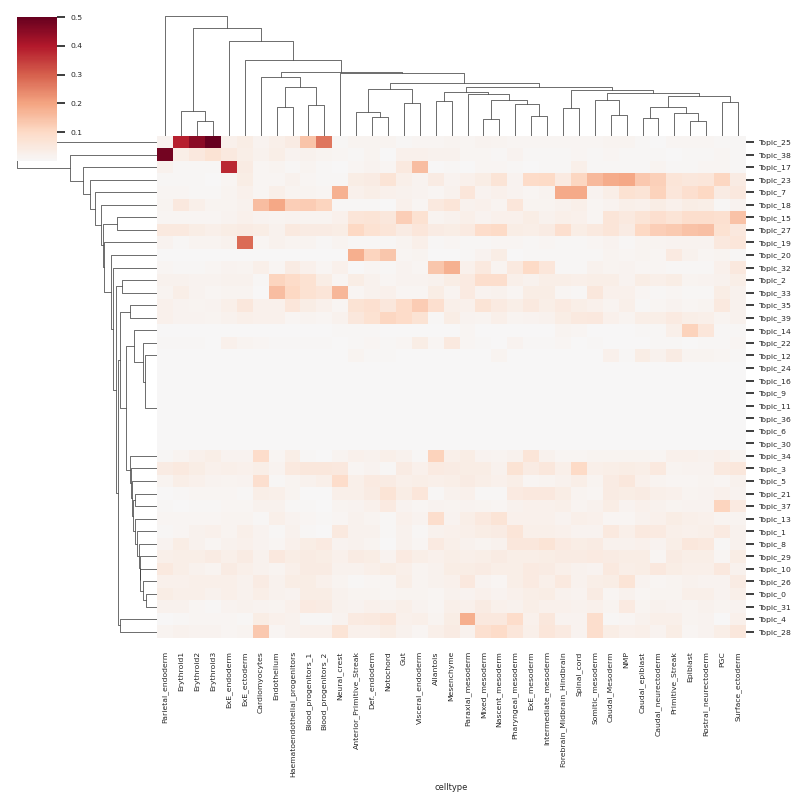

In [15]:
df_topic_celltype = plot_topic_activation_heatmap(
    rna_metacell, groupby_key=["celltype"], aggregation="mean"
)

In [16]:
sns.histplot(df_topic_celltype.max(axis=1))

<Axes: ylabel='Count'>

In [17]:
# removing topics not active highly in any of the celltypes
select_topics = [
    "Topic_" + str(k) for k in np.where(df_topic_celltype.max(axis=1) > 0.06)[0]
]

In [18]:
len(select_topics)

27

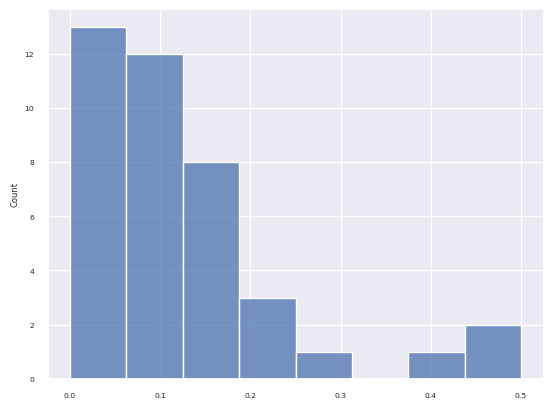

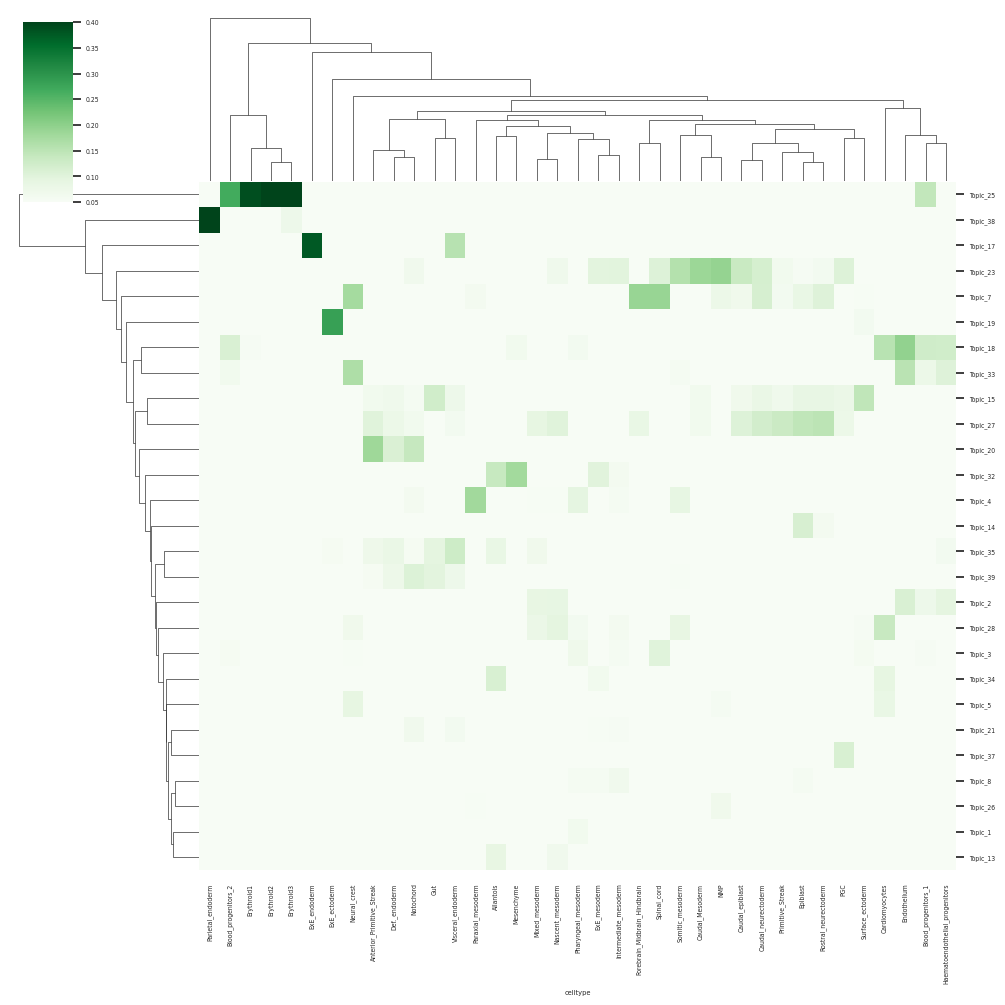

In [19]:
# masking low activations and removing topics not active
%matplotlib inline
sns.set(font_scale=0.4)
sns.clustermap(
    df_topic_celltype.loc[select_topics],
    cmap="Greens",
    vmin=0.05,
    vmax=0.4,
    figsize=(10, 10),
)

## 13. single cell level visualisation of scDoRI Topics

In Erythroid Trajectory from Blood Progenitors to Mature Erythroids: We can see that Topic 26 is active in progenitors whereas topic 4 and 9 capture a continuum of erythroid and progenitor programs along the trajectory

In transition of bipotent progenitors NMP (Neuromesodermal progenitors) to spinal cord or mesodermal lineage: We can see that Topic 34 and 7 capture transition to mesoderm and spinal cord respectively


In [20]:
for k in range(trainConfig.num_topics):
    rna_metacell.obs["Topic_" + str(k)] = scdori_latent[:, k]

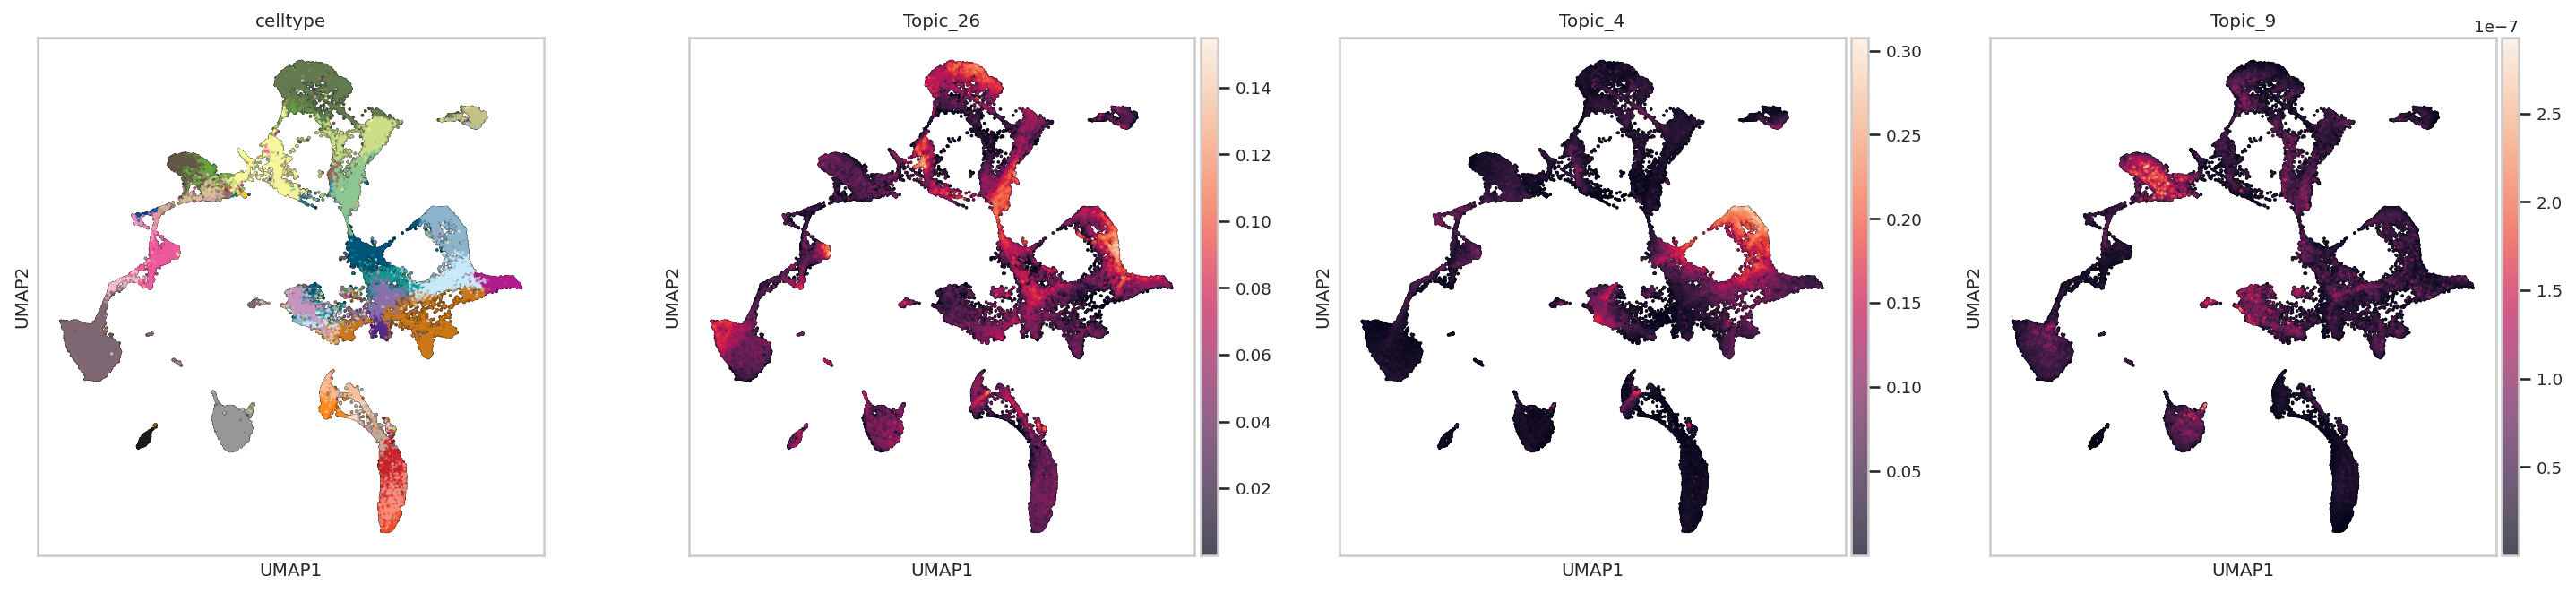

In [21]:
sns.set(font_scale=0.8)
sns.set_style("whitegrid")


with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": (150)}):
    sc.pl.umap(
        rna_metacell,
        color=["celltype", "Topic_26", "Topic_4", "Topic_9"],
        add_outline=True,
        outline_color=("white", "black"),
        size=10,
        legend_loc="none",
    )

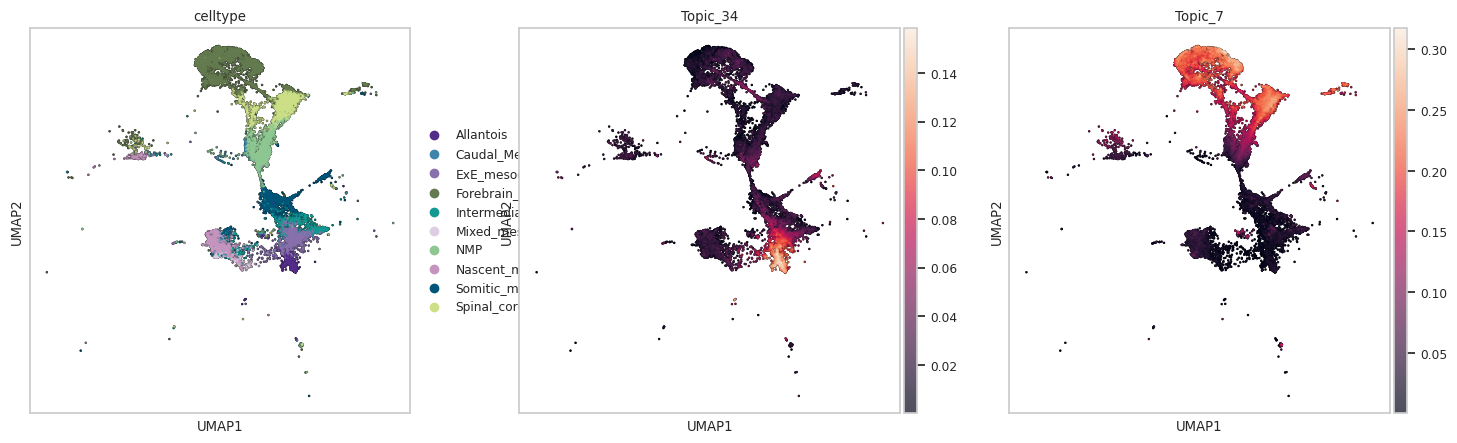

In [22]:
# visualising NMP transitions to Mesoderm [Topic 34] and Spinal Cord [Topic 7] Trajectory
sns.set(font_scale=0.8)
sns.set_style("whitegrid")

celltype_plot_list = [
    "Mixed_mesoderm",
    "Somitic_mesoderm",
    "Nascent_mesoderm",
    "Intermediate_mesoderm",
    "Forebrain_Midbrain_Hindbrain",
    "Spinal_cord",
    "Caudal_Mesoderm",
    "NMP",
    "ExE_mesoderm",
    "Allantois",
]
adata_plot = rna_metacell[rna_metacell.obs.celltype.isin(celltype_plot_list), :]

with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": (100)}):
    sc.pl.umap(
        adata_plot,
        color=["celltype", "Topic_34", "Topic_7"],
        add_outline=True,
        outline_color=("white", "black"),
        size=10,
    )

## 14. Computing Top genes per topic 

this can be used for further analysis such as gene-set enrichment


In [23]:
topic_gene_embedding = compute_topic_gene_matrix(model, device)

INFO:scdori._core.downstream:Done. computing topic gene matrix shape => (40, 4000)


/data/m015k/micromamba/envs/scdori_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/data/m015k/micromamba/envs/scdori_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


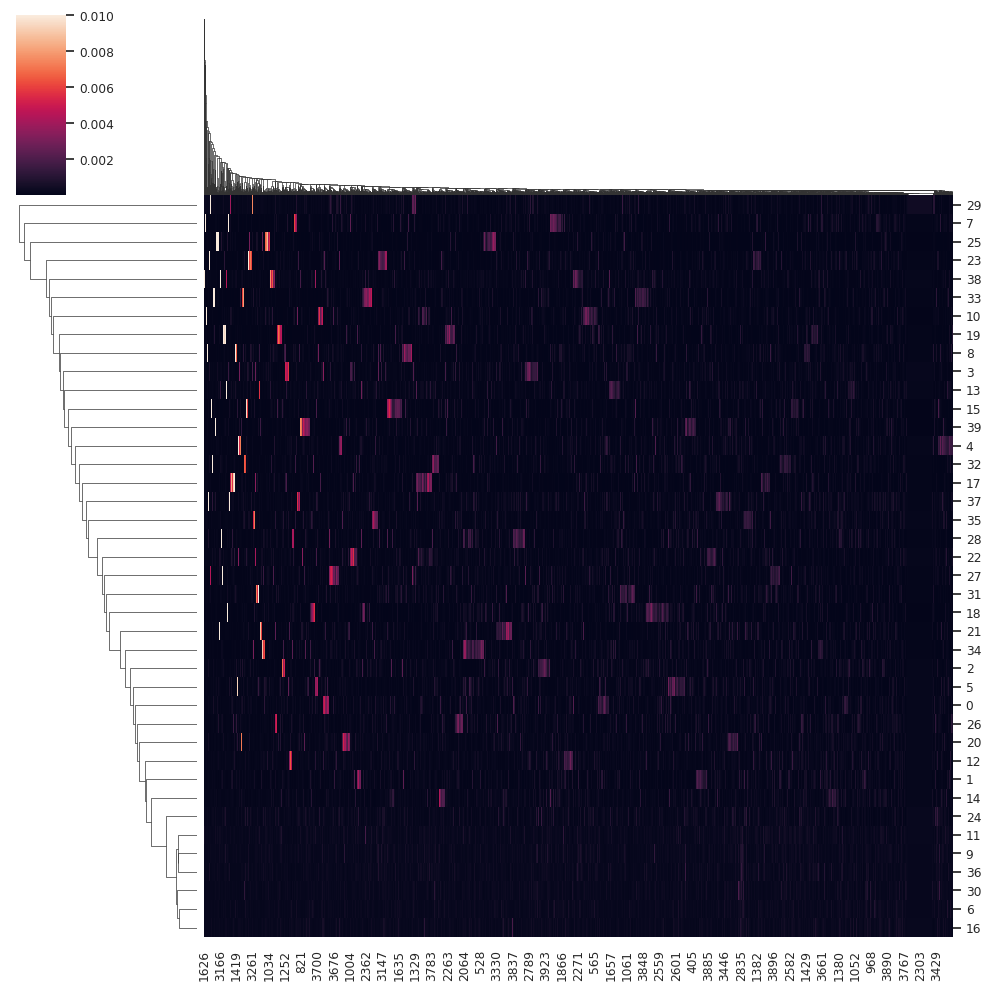

In [24]:
sns.clustermap(topic_gene_embedding, vmax=0.01)

## 15. Performing gene-set enrichment analysis on each topic

adapted from https://decoupler-py.readthedocs.io/en/latest/notebooks/msigdb.html#MSigDB-gene-sets

users can play around with other gene sets of their choice


In [25]:
# caution! this can create dependency issues in the conda environment
# !pip install decoupler
#!pip install liana
import decoupler as dc

In [26]:
# anndata with topic gene values
adata_gene = sc.AnnData(topic_gene_embedding)
adata_gene.obs.index = ["Topic_" + str(i) for i in range(model.num_topics)]
# dirty and incorrect hack to convert mouse gene names to human
adata_gene.var.index = [s.upper() for s in rna_metacell.var.index]
adata_gene.raw = adata_gene

In [27]:
# using msigdb
msigdb = dc.get_resource("MSigDB")

In [28]:
msigdb["collection"].unique()

<StringArray>
[                       'immunesigdb',                  'tf_targets_legacy',
                         'positional',               'cell_type_signatures',
              'go_cellular_component', 'chemical_and_genetic_perturbations',
                'mirna_targets_mirdb',                   'vaccine_response',
                     'cancer_modules',                  'reactome_pathways',
                    'tf_targets_gtrf',              'go_biological_process',
              'go_molecular_function',               'oncogenic_signatures',
                           'hallmark',                      'kegg_pathways',
                       'pid_pathways',           'human_phenotype_ontology',
                       'wikipathways',          'cancer_gene_neighborhoods',
               'mirna_targets_legacy',                  'biocarta_pathways']
Length: 22, dtype: string

In [29]:
# using msigdb celltype signature set
msigdb = dc.get_resource("MSigDB")
# Filter by hallmark
msigdb = msigdb[msigdb["collection"] == "cell_type_signatures"]

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(["geneset", "genesymbol"])]
msigdb

genesymbol            collection  \
                                           
3             A1BG  cell_type_signatures   
7             A1BG  cell_type_signatures   
9             A1BG  cell_type_signatures   
12            A1BG  cell_type_signatures   
14            A1BG  cell_type_signatures   
...            ...                   ...   
5521812        ZYX  cell_type_signatures   
5521814        ZYX  cell_type_signatures   
5521818        ZYX  cell_type_signatures   
5521916      ZZEF1  cell_type_signatures   
5522071       ZZZ3  cell_type_signatures   

                                                   geneset  
                                                            
3           GAO_LARGE_INTESTINE_ADULT_CI_MESENCHYMAL_CELLS  
7             HE_LIM_SUN_FETAL_LUNG_C1_PROXIMAL_BASAL_CELL  
9                HE_LIM_SUN_FETAL_LUNG_C2_PRE_PDC_DC5_CELL  
12       HE_LIM_SUN_FETAL_LUNG_C2_APOE_POS_M2_MACROPHAG...  
14                           GAUTAM_EYE_CORNEA_MELANOCYTES  
...                                                    ...  
5521812                   BUSSLINGER_DUODENAL_IMMUNE_CELLS  
5521814                   MANNO_MIDBRAIN_NEUROTYPES_HPERIC  
5521818            TRAVAGLINI_LUNG_BRONCHIAL_VESSEL_2_CELL  
5521916    GAO_ESOPHAGUS_25W_C4_FGFR1HIGH_EPITHELIAL_CELLS  
5522071                          MURARO_PANCREAS_BETA_CELL  

[192576 rows x 3 columns]

In [30]:
dc.run_ora(
    mat=adata_gene, net=msigdb, source="geneset", target="genesymbol", verbose=True
)

Running ora on mat with 40 samples and 4000 targets for 775 sources.


  0%|          | 0/40 [00:00<?, ?it/s]

In [31]:
acts = dc.get_acts(adata_gene, obsm_key="ora_estimate")

# We need to remove inf and set them to the maximum value observed
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

AnnData object with n_obs × n_vars = 40 × 775
    obsm: 'ora_estimate', 'ora_pvals'

In [32]:
# plot top celltype signatures per topic
df_acts = acts.to_df()
top_programs_per_topic = df_acts.idxmax(axis=1)
unique_top_programs = top_programs_per_topic.unique()
df_topic_program = df_acts.loc[:, unique_top_programs]

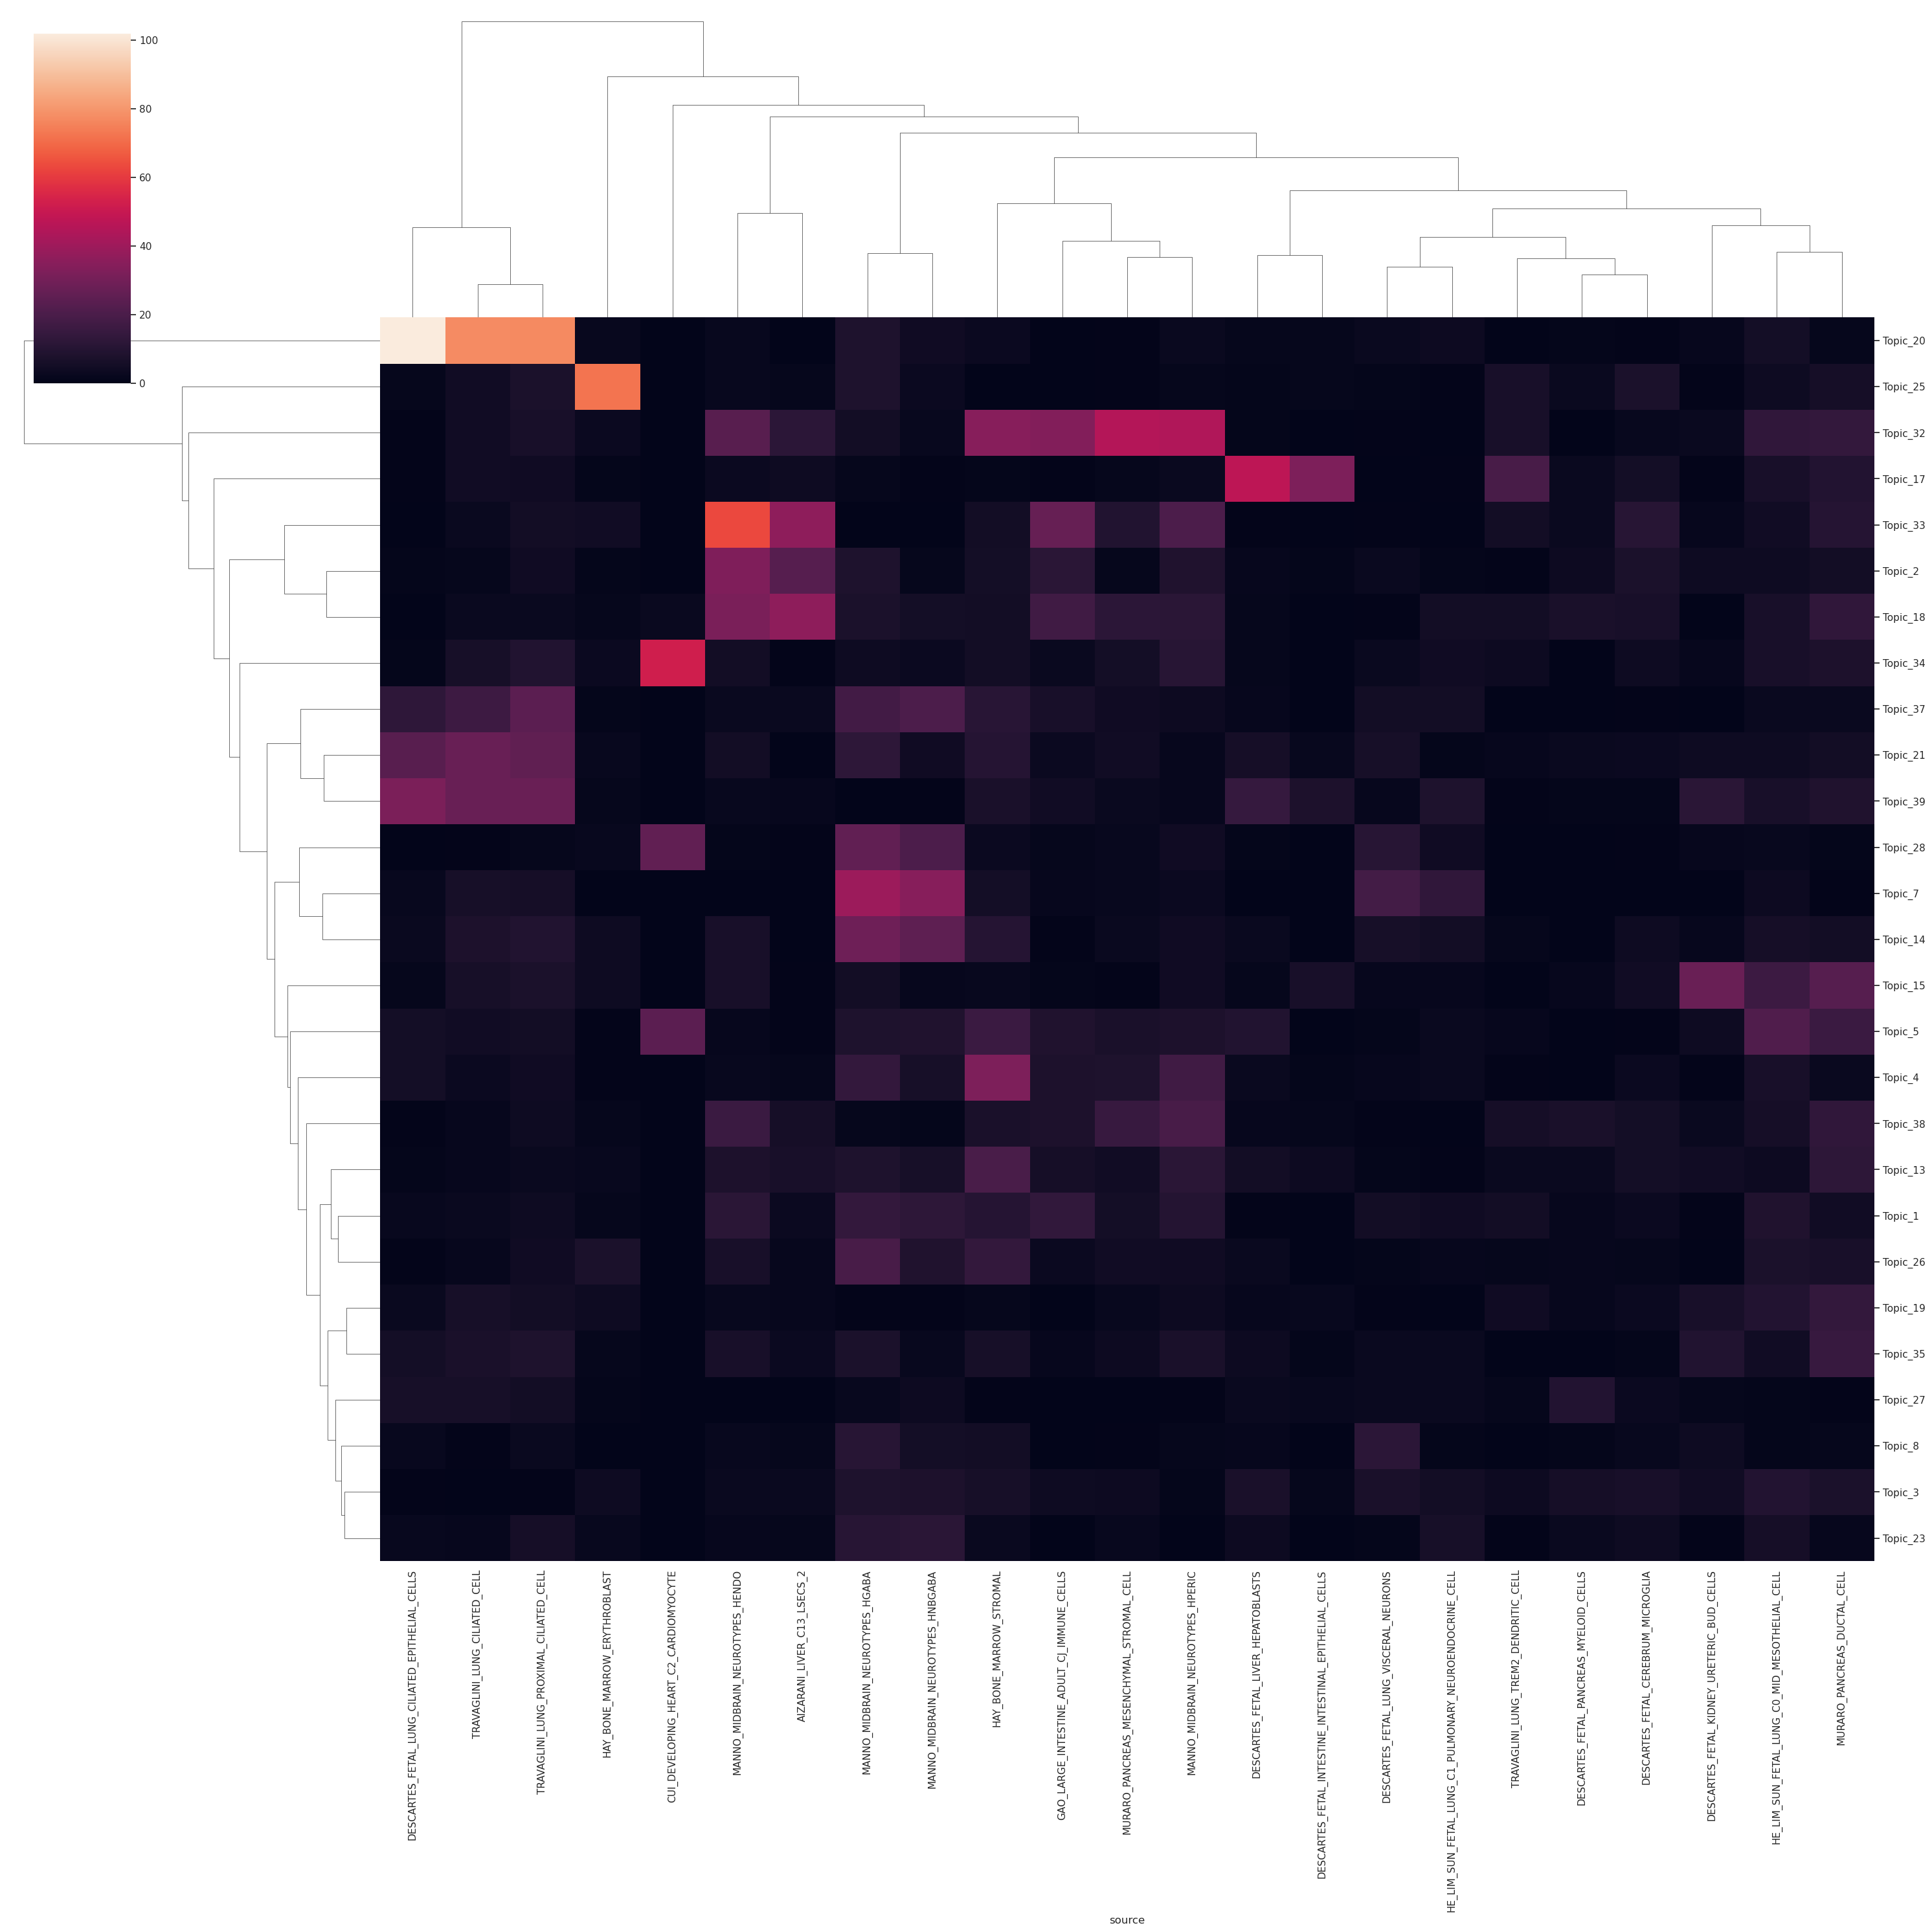

In [33]:
sns.set(font_scale=1)
sns.clustermap(df_topic_program.loc[select_topics], figsize=(30, 30))

###### 
we can see enrichments of respective celltype programs in different topics such Cardiomycoyte in topic 25, Erythroblast in topic 9, Liver hepatoblasts topic 19 

## 16. Computing and visualising peaks associated with each topic

peaks associated with a topic should capture co-accesibility patterns

we visualise average accesibility of peaks (on a UMAP) in different celltypes and their association to a topic, to see if topics have captured co-accesibility patterns. Each point on the UMAP is a peak.

In [34]:
umap_embedding_peaks, topic_peak_embedding = compute_topic_peak_umap(
    model,
    device,
    umap_n_neighbors=trainConfig.umap_n_neighbors,
    umap_min_dist=trainConfig.umap_min_dist,
    umap_random_state=trainConfig.umap_random_state
)

/data/m015k/micromamba/envs/scdori_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/data/m015k/micromamba/envs/scdori_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
INFO:scdori._core.downstream:Done. umap_embedding_peaks shape => (90000, 2) topic_embedding_peaks shape => (90000, 40)


In [35]:
## creating anndata with observations as peaks and values as topic association of each peak
adata_peak = sc.AnnData(topic_peak_embedding)
adata_peak.var.index = ["Topic_" + str(i) for i in range(model.num_topics)]
adata_peak.obs.index = atac_metacell.var.index
adata_peak.obsm["X_umap"] = umap_embedding_peaks

In [36]:
atac_metacell.obs["celltype"] = rna_metacell.obs["celltype"].copy()

In [37]:
# computing average accesiblity of peaks in each celltype
atac_metacell.layers["counts"] = atac_metacell.X
sc.pp.normalize_total(atac_metacell)
aggregated_atac = sc.get.aggregate(atac_metacell, by="celltype", func=["mean"])
aggregated_atac.X = aggregated_atac.layers["mean"]
sc.pp.normalize_total(aggregated_atac)
sc.pp.scale(aggregated_atac)

# adding average accesibility of each peak in a celltype to peak anndata
peak_celltype_df = aggregated_atac.to_df().T
peak_celltype_df = peak_celltype_df.loc[adata_peak.obs.index.values]
adata_peak.obs = pd.concat([adata_peak.obs, peak_celltype_df], axis=1)

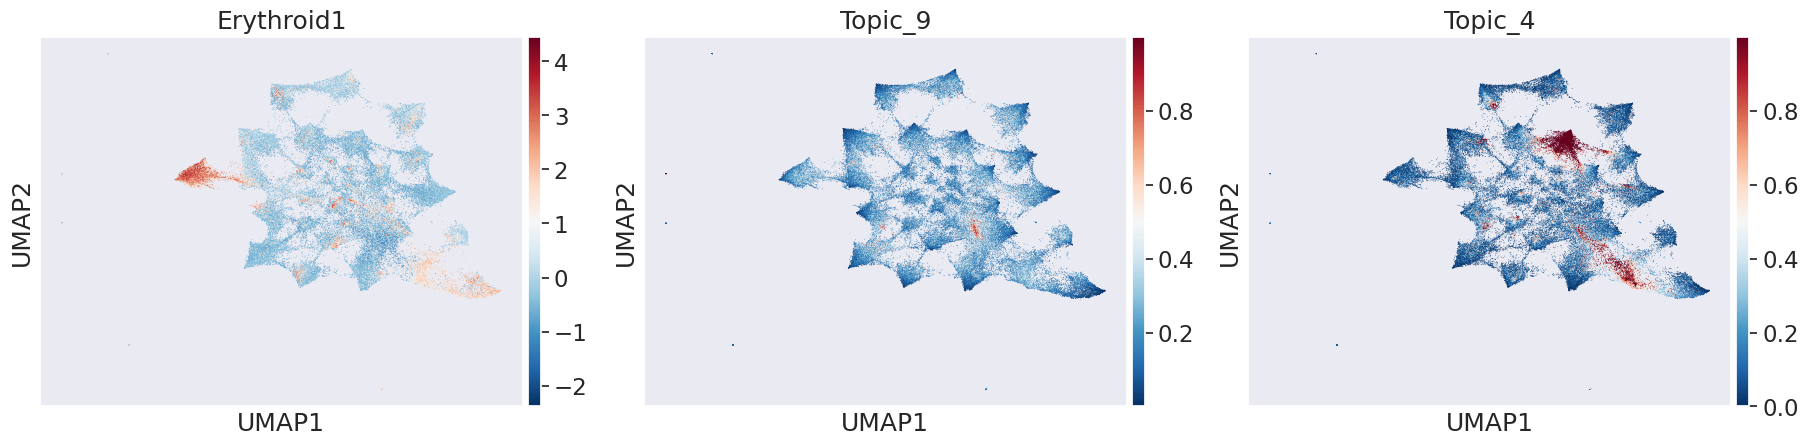

In [38]:
celltype_name = "Erythroid1"
sns.set(font_scale=1.5)
# topic 9 and 4 are active in erythroids from heatmap above
sc.pl.umap(
    adata_peak, color=[celltype_name, "Topic_9", "Topic_4"], cmap="RdBu_r"
)

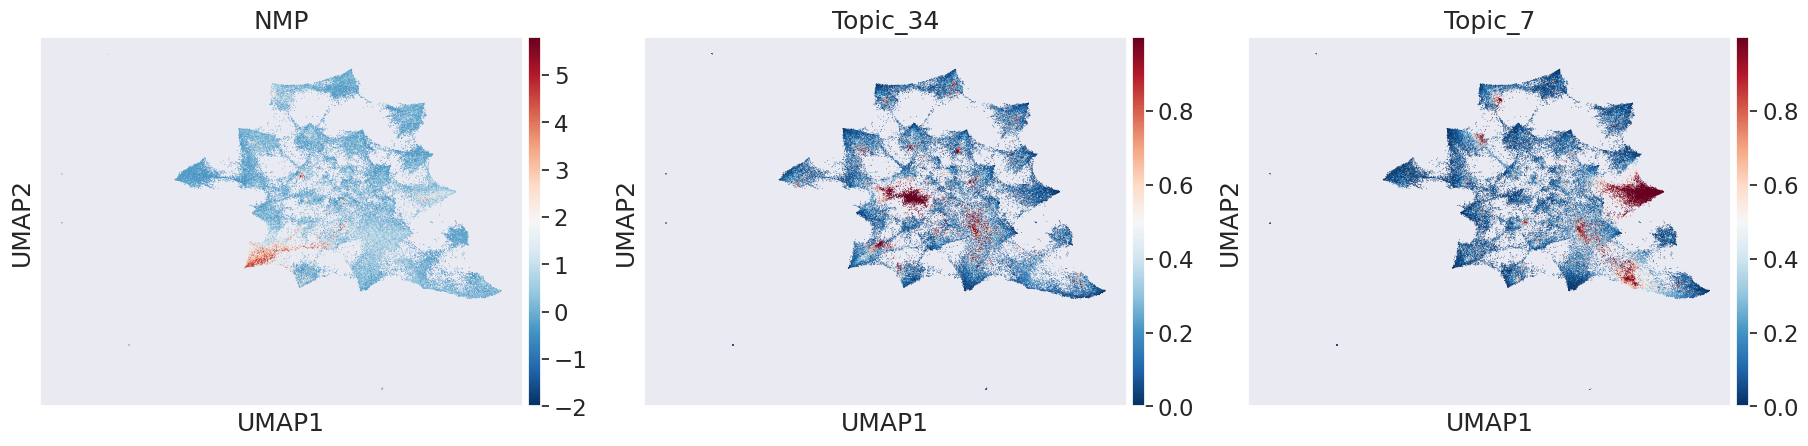

In [39]:
celltype_name = "NMP"
sns.set(font_scale=1.5)
sc.pl.umap(adata_peak, color=[celltype_name, "Topic_34", "Topic_7"], cmap="RdBu_r")

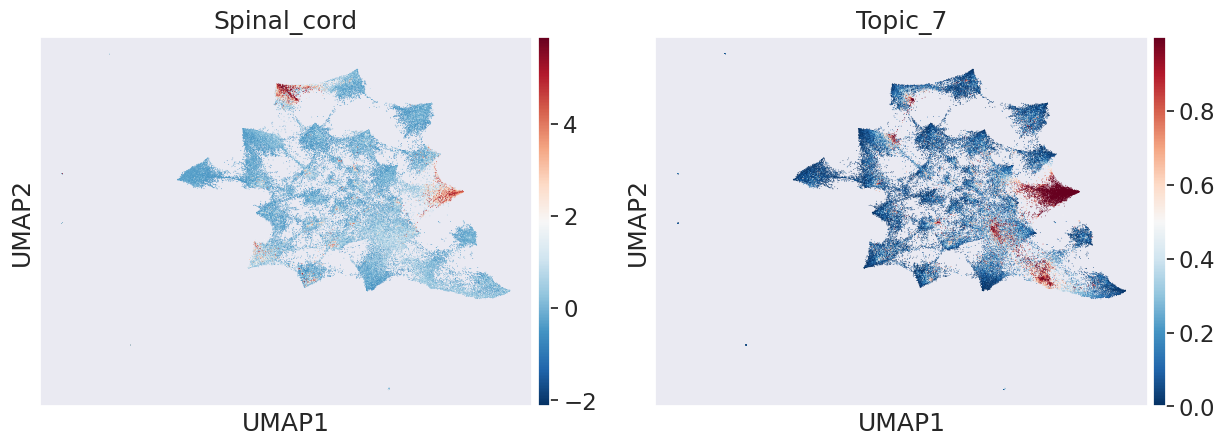

In [40]:
celltype_name = "Spinal_cord"
sns.set(font_scale=1.5)
sc.pl.umap(adata_peak, color=[celltype_name, "Topic_7"], cmap="RdBu_r")

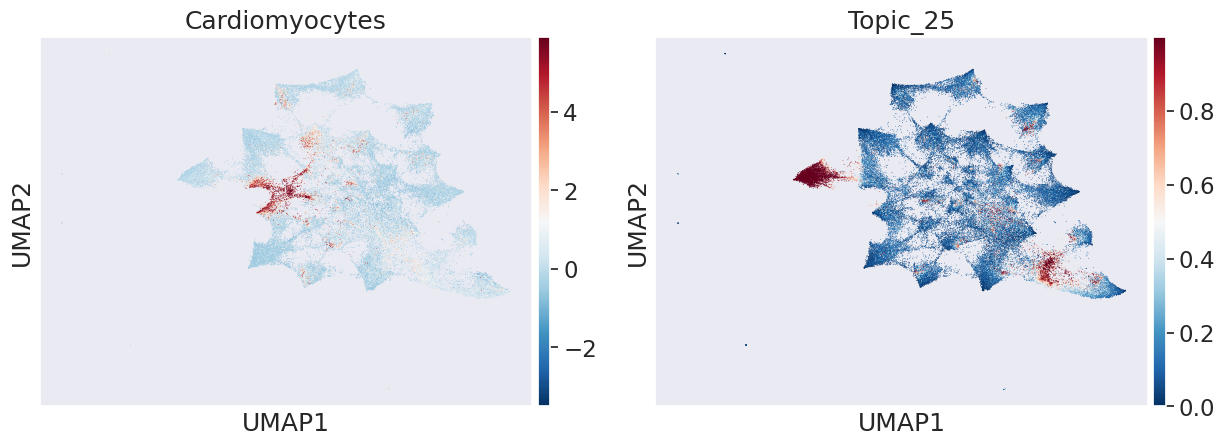

In [41]:
celltype_name = "Cardiomyocytes"
sns.set(font_scale=1.5)
sc.pl.umap(adata_peak, color=[celltype_name, "Topic_25"], cmap="RdBu_r")

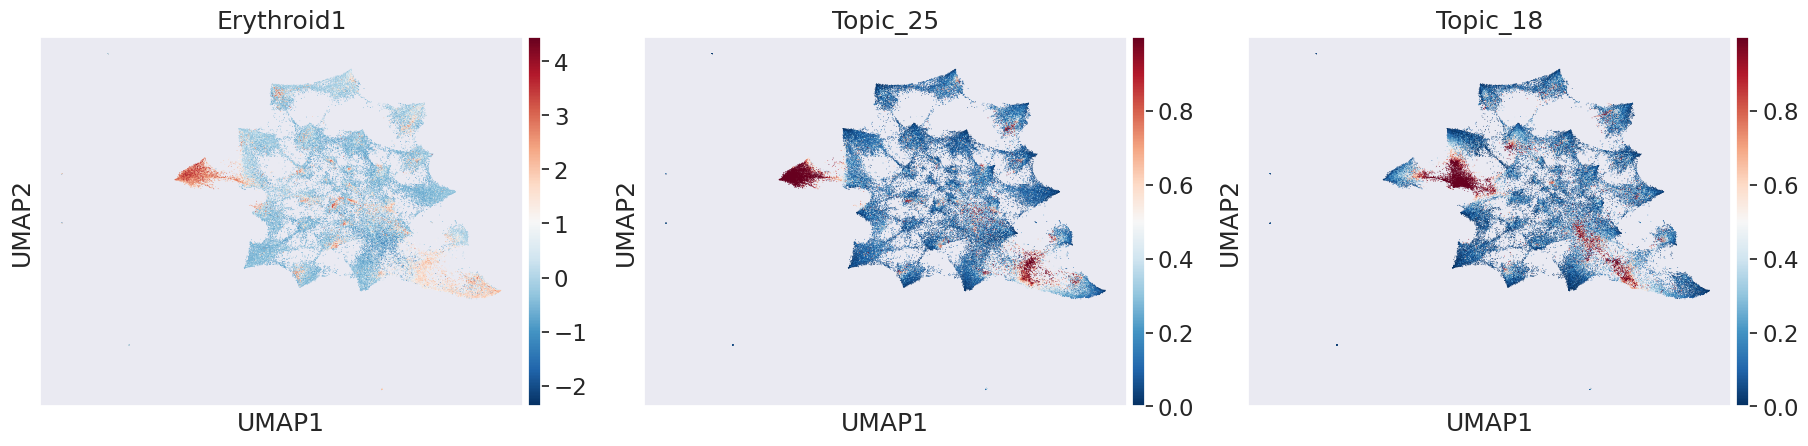

In [42]:
celltype_name = "Erythroid1"
sns.set(font_scale=1.5)
# topic 9 and 4 are active in erythroids from heatmap above
sc.pl.umap(
    adata_peak, color=[celltype_name, "Topic_25", "Topic_18"], cmap="RdBu_r"
)

## 17. Visualising TF binding scores on peaks

In [43]:
# adding insilico chipseq embeddings to peak anndata
tf_names = rna_metacell.var[rna_metacell.var.gene_type == "TF"].index.values

# Create a dictionary for activator and repressor insilico-chipseq binding score
tf_binding_data = {
    tf_name + "_activator_binding": insilico_act[:, i].numpy()
    for i, tf_name in enumerate(tf_names)
}
tf_binding_data.update(
    {
        tf_name + "_repressor_binding": np.abs(insilico_rep[:, i].numpy())
        for i, tf_name in enumerate(tf_names)
    }
)

# Convert the dictionary to a DataFrame
tf_binding_data_df = pd.DataFrame(tf_binding_data, index=adata_peak.obs.index)

In [44]:
# Concatenate new columns with existing obs
adata_peak.obs = pd.concat([adata_peak.obs, tf_binding_data_df], axis=1)
adata_peak.obs = tf_binding_data_df

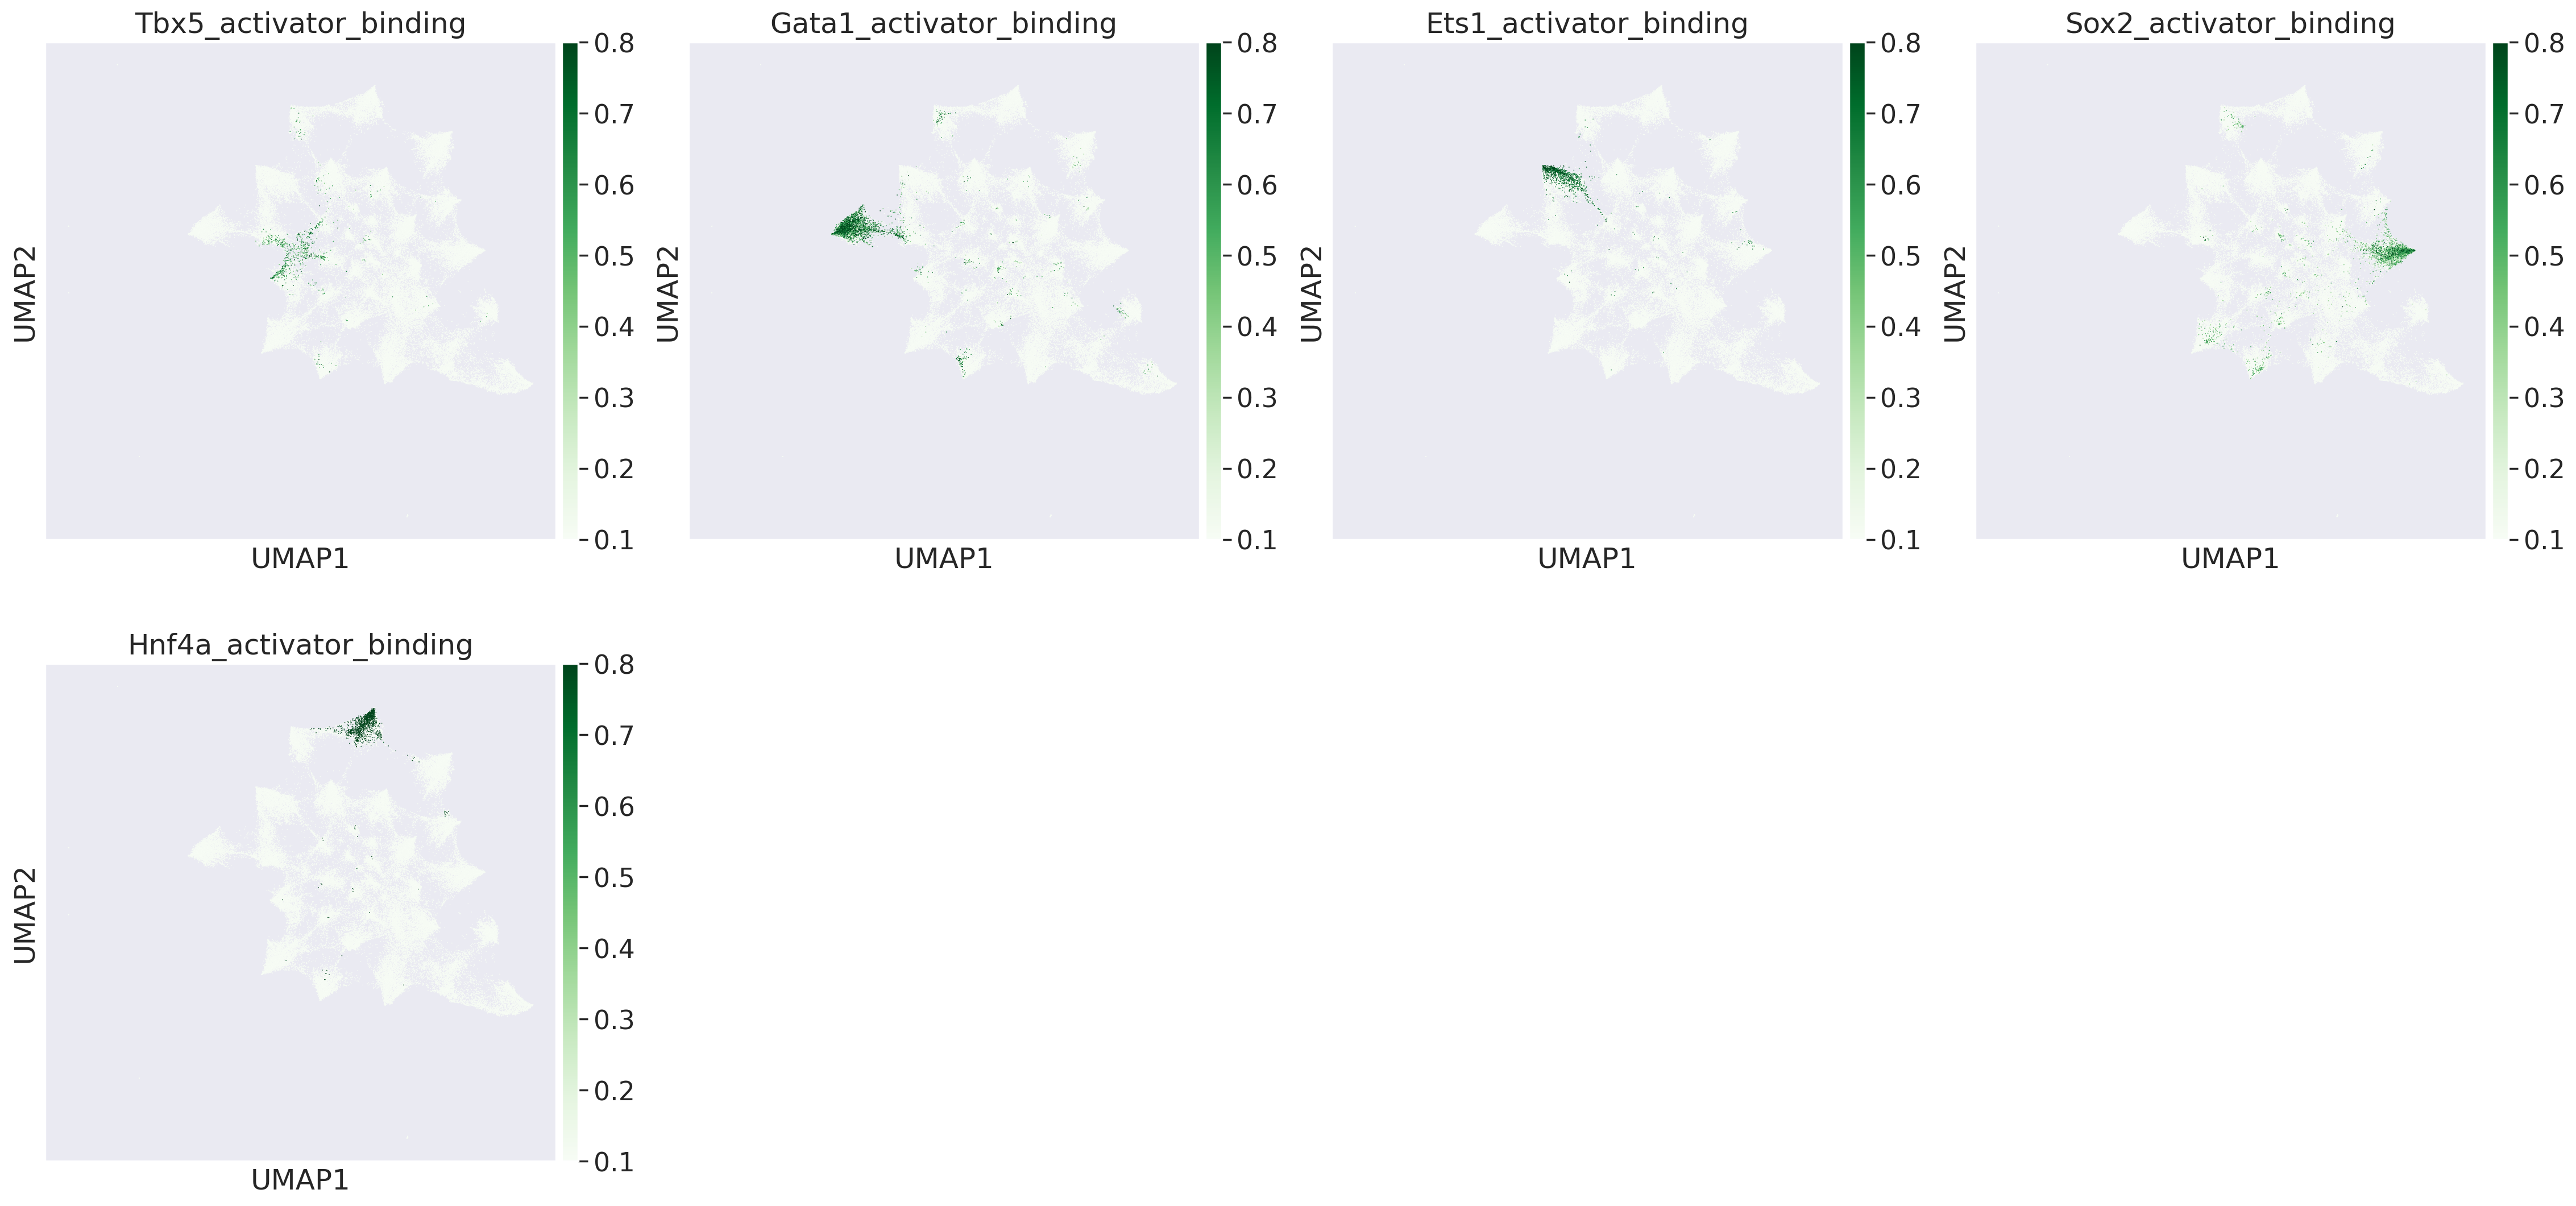

In [45]:
# visualsing TF binding scores on peak umap
sns.set(font_scale=1.5)

with plt.rc_context({"figure.figsize": (6, 6), "figure.dpi": (200)}):
    sc.pl.umap(
        adata_peak,
        color=[
            "Tbx5_activator_binding",
            "Gata1_activator_binding",
            "Ets1_activator_binding",
            "Sox2_activator_binding",
            "Hnf4a_activator_binding",
        ],
        cmap="Greens",
        vmin=0.1,
        vmax=0.8,
        sort_order=True,
    )

#### Computing eGRNs

## 18. Computing ATAC based GRNs with emprirical significance 
these GRNs do not use evidence of TF-gene co-expression 

activator GRNs here indicate if within a topic, peaks linked to a gene have accesible binding sites for a TF (from activator insilico-chipseq scores)

repressor GRNs here indicate if within a topic, peaks linked to a gene have non-accesible repressor binding sites for a TF (from repressor insilico-chipseq scores)

additionally we compute a background set of GRN values by shuffling insilico-chipseq scores, which are used to compute empirical significance 

In [ ]:
grn_act_atac = compute_atac_grn_activator_with_significance(
    model, device, cutoff_val=0.05, outdir="grn_act_atac", num_permutations=trainConfig.num_permutations
)

INFO:scdori._core.downstream:Computing significant ATAC-derived TF–gene links for activators. Output => grn_act_atac
INFO:scdori._core.downstream:Processing Topic 1/40


Processing Topic 1/40


Permutations for Topic 1: 100%|██████████| 1000/1000 [00:10<00:00, 91.57it/s]
INFO:scdori._core.downstream:Processing Topic 2/40


Processing Topic 2/40


Permutations for Topic 2: 100%|██████████| 1000/1000 [00:08<00:00, 113.15it/s]
INFO:scdori._core.downstream:Processing Topic 3/40


Processing Topic 3/40


Permutations for Topic 3: 100%|██████████| 1000/1000 [00:08<00:00, 114.40it/s]
INFO:scdori._core.downstream:Processing Topic 4/40


Processing Topic 4/40


Permutations for Topic 4: 100%|██████████| 1000/1000 [00:08<00:00, 114.03it/s]
INFO:scdori._core.downstream:Processing Topic 5/40


Processing Topic 5/40


Permutations for Topic 5: 100%|██████████| 1000/1000 [00:08<00:00, 113.98it/s]
INFO:scdori._core.downstream:Processing Topic 6/40


Processing Topic 6/40


Permutations for Topic 6: 100%|██████████| 1000/1000 [00:08<00:00, 113.95it/s]
INFO:scdori._core.downstream:Processing Topic 7/40


Processing Topic 7/40


Permutations for Topic 7: 100%|██████████| 1000/1000 [00:08<00:00, 113.78it/s]
INFO:scdori._core.downstream:Processing Topic 8/40


Processing Topic 8/40


Permutations for Topic 8: 100%|██████████| 1000/1000 [00:09<00:00, 104.43it/s]
INFO:scdori._core.downstream:Processing Topic 9/40


Processing Topic 9/40


Permutations for Topic 9: 100%|██████████| 1000/1000 [00:09<00:00, 102.15it/s]
INFO:scdori._core.downstream:Processing Topic 10/40


Processing Topic 10/40


Permutations for Topic 10: 100%|██████████| 1000/1000 [00:09<00:00, 102.66it/s]
INFO:scdori._core.downstream:Processing Topic 11/40


Processing Topic 11/40


Permutations for Topic 11: 100%|██████████| 1000/1000 [00:08<00:00, 112.74it/s]
INFO:scdori._core.downstream:Processing Topic 12/40


Processing Topic 12/40


Permutations for Topic 12: 100%|██████████| 1000/1000 [00:09<00:00, 102.80it/s]
INFO:scdori._core.downstream:Processing Topic 13/40


Processing Topic 13/40


Permutations for Topic 13: 100%|██████████| 1000/1000 [00:09<00:00, 100.26it/s]
INFO:scdori._core.downstream:Processing Topic 14/40


Processing Topic 14/40


Permutations for Topic 14: 100%|██████████| 1000/1000 [00:09<00:00, 100.42it/s]
INFO:scdori._core.downstream:Processing Topic 15/40


Processing Topic 15/40


Permutations for Topic 15: 100%|██████████| 1000/1000 [00:09<00:00, 100.45it/s]
INFO:scdori._core.downstream:Processing Topic 16/40


Processing Topic 16/40


Permutations for Topic 16: 100%|██████████| 1000/1000 [00:09<00:00, 107.60it/s]
INFO:scdori._core.downstream:Processing Topic 17/40


Processing Topic 17/40


Permutations for Topic 17: 100%|██████████| 1000/1000 [00:08<00:00, 114.74it/s]
INFO:scdori._core.downstream:Processing Topic 18/40


Processing Topic 18/40


Permutations for Topic 18: 100%|██████████| 1000/1000 [00:09<00:00, 102.61it/s]
INFO:scdori._core.downstream:Processing Topic 19/40


Processing Topic 19/40


Permutations for Topic 19: 100%|██████████| 1000/1000 [00:08<00:00, 112.41it/s]
INFO:scdori._core.downstream:Processing Topic 20/40


Processing Topic 20/40


Permutations for Topic 20: 100%|██████████| 1000/1000 [00:08<00:00, 113.80it/s]
INFO:scdori._core.downstream:Processing Topic 21/40


Processing Topic 21/40


Permutations for Topic 21: 100%|██████████| 1000/1000 [00:08<00:00, 113.50it/s]
INFO:scdori._core.downstream:Processing Topic 22/40


Processing Topic 22/40


Permutations for Topic 22: 100%|██████████| 1000/1000 [00:08<00:00, 113.93it/s]
INFO:scdori._core.downstream:Processing Topic 23/40


Processing Topic 23/40


Permutations for Topic 23: 100%|██████████| 1000/1000 [00:08<00:00, 114.28it/s]
INFO:scdori._core.downstream:Processing Topic 24/40


Processing Topic 24/40


Permutations for Topic 24: 100%|██████████| 1000/1000 [00:08<00:00, 113.49it/s]
INFO:scdori._core.downstream:Processing Topic 25/40


Processing Topic 25/40


Permutations for Topic 25: 100%|██████████| 1000/1000 [00:08<00:00, 113.21it/s]
INFO:scdori._core.downstream:Processing Topic 26/40


Processing Topic 26/40


Permutations for Topic 26: 100%|██████████| 1000/1000 [00:08<00:00, 112.32it/s]
INFO:scdori._core.downstream:Processing Topic 27/40


Processing Topic 27/40


Permutations for Topic 27: 100%|██████████| 1000/1000 [00:08<00:00, 111.65it/s]
INFO:scdori._core.downstream:Processing Topic 28/40


Processing Topic 28/40


Permutations for Topic 28: 100%|██████████| 1000/1000 [00:09<00:00, 103.62it/s]
INFO:scdori._core.downstream:Processing Topic 29/40


Processing Topic 29/40


Permutations for Topic 29: 100%|██████████| 1000/1000 [00:09<00:00, 101.13it/s]
INFO:scdori._core.downstream:Processing Topic 30/40


Processing Topic 30/40


Permutations for Topic 30: 100%|██████████| 1000/1000 [00:09<00:00, 102.28it/s]
INFO:scdori._core.downstream:Processing Topic 31/40


Processing Topic 31/40


Permutations for Topic 31: 100%|██████████| 1000/1000 [00:10<00:00, 99.85it/s]
INFO:scdori._core.downstream:Processing Topic 32/40


Processing Topic 32/40


Permutations for Topic 32: 100%|██████████| 1000/1000 [00:09<00:00, 102.39it/s]
INFO:scdori._core.downstream:Processing Topic 33/40


Processing Topic 33/40


Permutations for Topic 33: 100%|██████████| 1000/1000 [00:09<00:00, 100.57it/s]
INFO:scdori._core.downstream:Processing Topic 34/40


Processing Topic 34/40


Permutations for Topic 34: 100%|██████████| 1000/1000 [00:10<00:00, 99.57it/s]
INFO:scdori._core.downstream:Processing Topic 35/40


Processing Topic 35/40


Permutations for Topic 35: 100%|██████████| 1000/1000 [00:09<00:00, 100.43it/s]
INFO:scdori._core.downstream:Processing Topic 36/40


Processing Topic 36/40


Permutations for Topic 36: 100%|██████████| 1000/1000 [00:08<00:00, 113.45it/s]
INFO:scdori._core.downstream:Processing Topic 37/40


Processing Topic 37/40


Permutations for Topic 37: 100%|██████████| 1000/1000 [00:09<00:00, 105.79it/s]
INFO:scdori._core.downstream:Processing Topic 38/40


Processing Topic 38/40


Permutations for Topic 38:  30%|██▉       | 296/1000 [00:02<00:07, 99.99it/s] 

In [ ]:
# ATAC based GRN for repressors
grn_rep_atac = compute_atac_grn_repressor_with_significance(
    model, device, cutoff_val=0.05, outdir="grn_act_atac", num_permutations=trainConfig.num_permutations
)

## 19. Computing final GRNs

to compute these, we use the significant ATAC based GRNs derived previously and do element wise product with GRNs learnt by scDoRI incorproating TF - gene co-expression

In [ ]:
# calculating TF-expression per topic
# either from scdori model weights or from true data
# using true expression here
tf_normalised = get_tf_expression(
    "True",
    model,
    device,
    all_dataset_loader,
    rna_metacell,
    atac_metacell,
    num_cells,
    tf_indices,
    onehot_batch,
    trainConfig,
)

In [ ]:
tf_normalised.shape

In [ ]:
# compute final GRNs which use the significant ATAC based GRNs derived above
grn_act, grn_rep = compute_significant_grn(
    model,
    device,
    cutoff_val_activator=0.05,
    cutoff_val_repressor=0.05,
    tf_normalised=tf_normalised.detach().cpu().numpy(),
    outdir="grn_act_atac",
)

In [ ]:
# save regulons per TF
save_regulons(
    grn_act,
    tf_names=tf_names,
    gene_names=rna_metacell.var.index.values,
    num_topics=model.num_topics,
    output_dir="grn_act_atac",
    mode="activator",
)

In [ ]:
# save regulons per TF
save_regulons(
    grn_rep,
    tf_names=tf_names,
    gene_names=rna_metacell.var.index.values,
    num_topics=model.num_topics,
    output_dir="grn_act_atac",
    mode="repressor",
)

In [107]:
# loading saved GRN
grn_act = np.load("grn_act_atac/grn_activator__0.05.npy")
grn_rep = np.load("grn_act_atac/grn_repressor__0.05.npy")

In [ ]:
grn_act.shape  # num_topics x num_tfs x num_genes

## 20. Computing and plotting top activator TFs per topic

In [ ]:
# plotting TF activity across topics
tf_names = rna_metacell.var[rna_metacell.var.gene_type == "TF"].index.values

# plot top k activators per topic
df_topic_activator, top_regulators = get_top_activators_per_topic(
    grn_act,
    tf_names,
    scdori_latent,
    selected_topics=None,
    top_k=2,
    clamp_value=1e-8,
    zscore=True,
    figsize=(25, 10),
    out_fig=None,
)

In [ ]:
df_topic_activator  # matrix of Topic TF activities

## 21. Computing and plotting TF activity per cell

In [ ]:
# computing TF activity per cell
cell_tf_act = compute_activator_tf_activity_per_cell(
    grn_act,
    tf_names,
    scdori_latent,
    selected_topics=None,
    clamp_value=1e-8,
    zscore=True,
)

In [ ]:
# aggregating activity per celltype
df_celltype_tf = pd.DataFrame(cell_tf_act, columns=tf_names)
df_celltype_tf["celltype"] = rna_metacell.obs["celltype"].values
df_celltype_tf = df_celltype_tf.groupby("celltype").mean()
df_celltype_tf = df_celltype_tf.fillna(0)
# removing TF with 0/Nan activity
df_celltype_tf = df_celltype_tf.loc[:, (df_celltype_tf != 0).any(axis=0)]

In [ ]:
# top TFs per celltype
for k in df_celltype_tf.index:
    print(df_celltype_tf.loc[k].sort_values(ascending=False)[:5])

In [ ]:
sns.clustermap(df_celltype_tf, cmap="RdBu_r", vmin=-4, vmax=4, figsize=(20, 15))

In [115]:
# visualing TF activity on UMAP
df_cell_tf = pd.DataFrame(cell_tf_act, columns=[s + "_activity" for s in tf_names])
df_cell_tf.index = rna_metacell.obs.index.values
obs_df = pd.concat([rna_metacell.obs, df_cell_tf], axis=1)

In [ ]:
for k in df_cell_tf.columns:
    rna_metacell.obs[k] = df_cell_tf[k].values

In [ ]:
sc.pl.umap(
    rna_metacell,
    color=[
        "celltype",
        "Gata1_activity",
        "Sox10_activity",
        "Gata6_activity",
        "Ets1_activity",
        "Hnf4a_activity",
        "T_activity",
        "Prrx1_activity",
        "Tbx5_activity",
        "Pou5f1_activity",
    ],
    vmin=-2,
    vmax=4,
    cmap="RdBu_r",
)

## 22. visualising downstream target genes of a TF

In [ ]:
tf_plot = "Gata6"

tf_index = list(tf_names).index(tf_plot)
tf_index

In [ ]:
df_topic_activator[tf_plot].sort_values(ascending=False)[:5]

##### 
since Gata4 is active in multiple topics ( and associated cellltype), we obtain different targets for it in the respective context

In [160]:
topic_num = [38]  # endodermal topics
# adjust this value to get more stringent/ strongly regulated downstream taregts
target_gene_idx = np.where(grn_act[topic_num, tf_index, :].sum(axis=0) > 0.0)[
    0
]
genes_endoderm = rna_metacell.var_names[target_gene_idx]

In [ ]:
genes_endoderm

In [169]:
topic_num = [5]  # cardiomyocyte specific topic
target_gene_idx = np.where(grn_act[topic_num, tf_index, :].sum(axis=0) > 0.0)[0]
genes_cardiomyocytes = rna_metacell.var_names[target_gene_idx]

In [ ]:
genes_cardiomyocytes

In [ ]:
# plotting downstream expression of target genes
rna_metacell.X = rna_metacell.layers["counts"]
# normalsing raw counts
sc.pp.normalize_total(rna_metacell)
sc.pp.log1p(rna_metacell)

sc.tl.score_genes(rna_metacell, genes_endoderm, score_name="Gata6_endoderm_target")
sc.tl.score_genes(
    rna_metacell, genes_cardiomyocytes, score_name="Gata6_cardiomyocyte_target"
)

In [ ]:
# visualing cell-types on scDoRI computed UMAP
sns.set(font_scale=1)
sns.set_style("whitegrid")
with plt.rc_context({"figure.figsize": (7, 7), "figure.dpi": (200)}):
    sc.pl.umap(
        rna_metacell,
        color=[
            "celltype",
            "Gata6",
            "Gata6_endoderm_target",
            "Gata6_cardiomyocyte_target",
        ],
        add_outline=True,
        outline_color=("white", "black"),
        size=10,
        cmap="RdBu_r",
        legend_loc=None,
    )

##### 
we can clearly see that scDoRI finds differential downstream targets for the same TF in different contexts

we can visualise the TF binding profiles to confirm that these differences are coming from chromatin differences between states

In [ ]:
# visualsing TF binding scores and topic values where TF is active, on peak umap
sns.set(font_scale=1)
# topic 3 and 19 are endoderm related and topic 25 is cardiomyocyte specific
with plt.rc_context({"figure.figsize": (3, 3), "figure.dpi": (150)}):
    sc.pl.umap(
        adata_peak, color=["Gata4_activator_binding"], cmap="Greens", sort_order=True
    )

In [ ]:
# visualsing TF binding scores and topic values where TF is active, on peak umap
sns.set(font_scale=1)
# topic 3 and 19 are endoderm related and topic 25 is cardiomyocyte specific
with plt.rc_context({"figure.figsize": (3, 3), "figure.dpi": (200)}):
    sc.pl.umap(
        adata_peak,
        color=["Topic_3", "Topic_19", "Topic_25"],
        cmap="Greens",
        vmin=0.8,
        vmax=1,
        sort_order=True,
    )

##### 
we can see that Gata4 binds to regulatory regions associated with different topics and can regulate different set of genes in those topics respectively 

## 23. Repressor analysis

In [ ]:
df_topic_repressor, top_regulators_repressor = get_top_repressor_per_topic(
    grn_rep,
    tf_names,
    scdori_latent,
    selected_topics=None,
    top_k=20,
    clamp_value=1e-8,
    zscore=True,
    figsize=(25, 10),
    out_fig=None,
)

In [ ]:
cell_tf_rep = compute_repressor_tf_activity_per_cell(
    grn_rep,
    tf_names,
    scdori_latent,
    selected_topics=None,
    clamp_value=1e-8,
    zscore=True,
)

In [ ]:
df_celltype_tf_rep = pd.DataFrame(cell_tf_rep, columns=tf_names)
df_celltype_tf_rep["celltype"] = rna_metacell.obs["celltype"].values
df_celltype_tf_rep = df_celltype_tf_rep.groupby("celltype").mean()

## 24. visualising enhancer gene links

In [180]:
# peaks gene links used by scdori
gene_peak = (model.gene_peak_factor_learnt.detach().cpu().numpy()) * (
    model.gene_peak_factor_fixed.detach().cpu().numpy()
)

In [ ]:
gene_peak.shape

In [188]:
gene_name = "Fosb"
gene_index = list(rna_metacell.var_names).index(gene_name)

# change this threshold to obtain more links
enhancers = np.where(gene_peak[gene_index, :] > 0.99)[0]
enhancers = atac_metacell.var_names[enhancers]

##### 
plotting accesibility of Tal1 enhancers across celltypes

In [ ]:
peak_gene_celltype = peak_celltype_df.loc[enhancers]
peak_gene_celltype

In [ ]:
sns.clustermap(peak_celltype_df.loc[enhancers], cmap="RdBu_r", vmin=-5, vmax=5)

#### 
plotting Tal1 expression and net accesibility of its predcited enhancers across celltypes

In [194]:
atac_metacell.X = atac_metacell.layers["counts"]
# normalsing raw counts
sc.pp.normalize_total(atac_metacell)
sc.tl.score_genes(atac_metacell, enhancers, score_name="Fosb_enhancer_accesibility")

In [ ]:
rna_metacell.obs["Fosb_enhancer_accesibility"] = atac_metacell.obs[
    "Fosb_enhancer_accesibility"
].values

In [ ]:
sns.set(font_scale=1)
sns.set_style("whitegrid")
with plt.rc_context({"figure.figsize": (7, 7), "figure.dpi": (200)}):
    sc.pl.umap(
        rna_metacell,
        color=["celltype", "Fosb", "Fosb_enhancer_accesibility"],
        add_outline=True,
        outline_color=("white", "black"),
        size=10,
        cmap="YlGnBu",
        vmin=0,
        vmax=1,
        legend_loc=None,
    )